# **Final Project - SENG 550**
#### Taking your diabetes medication?
##### Group Memebers:
- Pin Long - 30068063
- Hashir Ahmed - 30070165
- Moiz Abdullah - 30066638
- Rifat Haque - 30068063
#### ** This document will cover: **
+  ####*Part 1:* Read and parse the initial dataset. Perform One hot and other data preprocessing.
+  ####*Part 2:* Exploratory Data Analysis (EDA)
+  ####*Part 3:* Split dataset, then create and evaluate baseline and improved models. (For Logistic Regression, Naive Bayes, and Decision Tree Models)

## ** Part 1: Read and parse the initial dataset **

In [0]:
# File paths
# From: https://www.kaggle.com/datasets/jimschacko/10-years-diabetes-dataset?select=diabetes.csv
trainFilePath = '/FileStore/tables/diabetes.csv'

# Read the text files
diabetesRDD = sc.textFile(trainFilePath, 8)

# Cache the RDD after any action such that it does not need to be read again
diabetesRDD.cache()

Out[83]: /FileStore/tables/diabetes.csv MapPartitionsRDD[677] at textFile at NativeMethodAccessorImpl.java:0

#### Print some basic information of the files

In [0]:
print(diabetesRDD.count())

print(diabetesRDD.take(4)) # Print first few rows

101767
['id,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted', '1,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO', '2,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No

#### ** (1b) Data preprocessing **
1. Convert csv lines to a list of lines, Select only the rows we want. Also convert any number input values to its proper type.
2. Filter out the row without data columns
3. (Multi-Part) Perform 1 hot encoding on all categorical columns. Then we will make a new dataframe with only the features and labels columns. This will be used for training our models.

In [0]:
# 1. Convert csv lines to a list of lines, Select only the rows we want. Also convert any number input values to its proper type.
def extractFields(diabeteRDDRecord):
    """Creates a list consisting of the rows with only the columns that we need to build our model

    Args:
        diabetesRDDRecord : a comma separated string consisting of all fields in the data set.

    Returns:
        extracted record: Most records from it.
        race - 3, gender - 4, age - 5, medical_specialty - 12, num_lab_procedures - 13, num_procedures - 14, num_medications - 15, number_outpatient - 16, number_emergency - 17,
        number_inpatient - 18, number_diagnoses - 22, max_glu_serum - 23, A1Cresult - 24, metformin - 25, repaglinide - 26, nateglinide - 27,
        chlorpropamide - 28, glimepiride - 29, acetohexamide - 30, glipizide - 31, glyburide - 32, tolbutamide - 33, pioglitazone - 34, rosiglitazone - 35, acarbose - 36, miglitol - 37,
        troglitazone - 38, tolazamide - 39, examide - 40, citoglipton - 41, insulin - 42, glyburide.metformin - 43, glipizide.metformin - 44, glimepiride.pioglitazone - 45, 
        metformin.rosiglitazone - 46, metformin.pioglitazone - 47, change - 48, diabetesMed - 49, readmitted - 50
    """
   
    # race - 3, gender - 4, age - 5, medical_specialty - 12, num_lab_procedures - 13, num_procedures - 14, num_medications - 15, number_outpatient - 16, number_emergency - 17,
    # number_inpatient - 18, number_diagnoses - 22, max_glu_serum - 23, A1Cresult - 24, metformin - 25, repaglinide - 26, nateglinide - 27,
    # chlorpropamide - 28, glimepiride - 29, acetohexamide - 30, glipizide - 31, glyburide - 32, tolbutamide - 33, pioglitazone - 34, rosiglitazone - 35, acarbose - 36, miglitol - 37,
    # troglitazone - 38, tolazamide - 39, insulin - 42, glyburide.metformin - 43, glipizide.metformin - 44, glimepiride.pioglitazone - 45, 
    # metformin.rosiglitazone - 46, metformin.pioglitazone - 47, change - 48, diabetesMed - 49, readmitted - 50
    fieldsList = diabeteRDDRecord.split(',')
    
    notFirst = (fieldsList[0] != 'id')
    
    # The first row is the column name row. We will convert column of any rows other than the first.
    if notFirst:
        joinedlist = [fieldsList[3], fieldsList[4], fieldsList[5], fieldsList[12], int(fieldsList[13]), int(fieldsList[14]), int(fieldsList[15]),
                      int(fieldsList[16]), int(fieldsList[17]), int(fieldsList[18]), int(fieldsList[22])] + fieldsList[23:40] + fieldsList[42:]
    else:
        joinedlist = [fieldsList[3], fieldsList[4], fieldsList[5], fieldsList[12], fieldsList[13], fieldsList[14], fieldsList[15],
                  fieldsList[16], fieldsList[17], fieldsList[18], fieldsList[22]] + fieldsList[23:40] + fieldsList[42:]
    
    # Replace all ? with None
    size = len(joinedlist)
    for index in range(size):
        if (type(joinedlist[index]) != type(1)):
            joinedlist[index] = joinedlist[index].replace('?', 'None').replace('.', '_')
        
        # For target label, we will convert the categorical output to a numberical 1 or 0 output
        if (notFirst and index == (size - 2)):
            if (joinedlist[index] == 'Yes'):
                joinedlist[index] = 1
            else:
                joinedlist[index] = 0
    
    return joinedlist

p1DiabetesRDD = diabetesRDD.map(extractFields)

fields = p1DiabetesRDD.take(4)

print(fields)

# Get a list of all field names, and a list of names for all categorical (non numerical) fields
allFields = fields[0]
categoricalFields = allFields[:4] + allFields[11:-2] + allFields[-1:]

print(categoricalFields)

[['race', 'gender', 'age', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide_metformin', 'glipizide_metformin', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone', 'change', 'diabetesMed', 'readmitted'], ['Caucasian', 'Female', '[0-10)', 'Pediatrics-Endocrinology', 41, 0, 1, 0, 0, 0, 1, 'None', 'None', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 0, 'NO'], ['Caucasian', 'Female', '[10-20)', 'None', 59, 0, 18, 0, 0, 0, 9, 'None', 'None', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',

In [0]:
# 2. Filter out the row without the data columns
def filterLines(diabeteRDDRecord):
    """ Skips lines with metadata and label information
    Args:
        diabeteRDDRecord : a line from the diabete file.

    Returns:
        True - if line is not metadata/label; False otherwise
    """
    
    if not 'race' in diabeteRDDRecord[0]:
        return True 
    else:
        return False

p2DiabetesRDD = p1DiabetesRDD.filter(filterLines)

print(p2DiabetesRDD.take(2))

[['Caucasian', 'Female', '[0-10)', 'Pediatrics-Endocrinology', 41, 0, 1, 0, 0, 0, 1, 'None', 'None', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 0, 'NO'], ['Caucasian', 'Female', '[10-20)', 'None', 59, 0, 18, 0, 0, 0, 9, 'None', 'None', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Up', 'No', 'No', 'No', 'No', 'No', 'Ch', 1, '>30']]


In [0]:
# 3. (Multi-Part) Perform 1 hot encoding on all categorical columns. Then we will make a new dataframe with only the features and labels columns. This will be used for training our models.
df = p2DiabetesRDD.toDF(allFields)

df.printSchema()
display(df)

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: long (nullable = true)
 |-- num_procedures: long (nullable = true)
 |-- num_medications: long (nullable = true)
 |-- number_outpatient: long (nullable = true)
 |-- number_emergency: long (nullable = true)
 |-- number_inpatient: long (nullable = true)
 |-- number_diagnoses: long (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nullable = true)
 |-- glipizide: string (nullable = true)
 |-- glyburide: string (nullable = true)
 |-- tolbutamide: string (nullable = true)
 |-- pioglitazone: string (nullable = true)

race gender age medical_specialty num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide insulin glyburide_metformin glipizide_metformin glimepiride_pioglitazone metformin_rosiglitazone metformin_pioglitazone change diabetesMed readmitted Caucasian Female [0-10) Pediatrics-Endocrinology 41 0 1 0 0 0 1 None None No No No No No No No No No No No No No No No No No No No No No No 0 NO Caucasian Female [10-20) None 59 0 18 0 0 0 9 None None No No No No No No No No No No No No No No No Up No No No No No Ch 1 >30 AfricanAmerican Female [20-30) None 11 5 13 2 0 1 6 None None No No No No No No Steady No No No No No No No No No No No No No No No 1 NO Caucasian Male [30-40) None 44 1 16 0 0 0 7 None None No No No No No No No No No No No No No No No Up No No No No No Ch 1 NO Caucasian Male [40-50) None 51 0 8 0 0 0 5 None None No No No No No No Steady No No No No No No No No Steady No No No No No Ch 1 NO Caucasian Male [50-60) None 31 6 16 0 0 0 9 None None No No No No No No No No No No No No No No No Steady No No No No No No 1 >30 Caucasian Male [60-70) None 70 1 21 0 0 0 7 None None Steady No No No Steady No No No No No No No No No No Steady No No No No No Ch 1 NO Caucasian Male [70-80) None 73 0 12 0 0 0 8 None None No No No No No No No Steady No No No No No No No No No No No No No No 1 >30 Caucasian Female [80-90) None 68 2 28 0 0 0 8 None None No No No No No No Steady No No No No No No No No Steady No No No No No Ch 1 NO Caucasian Female [90-100) InternalMedicine 33 3 18 0 0 0 8 None None No No No No No No No No No No Steady No No No No Steady No No No No No Ch 1 NO AfricanAmerican Female [40-50) None 47 2 17 0 0 0 9 None None No No No No No No No No No No No No No No No Steady No No No No No No 1 >30 AfricanAmerican Male [60-70) None 62 0 11 0 0 0 7 None None No No No No No No No Up No No No No No No No Steady No No No No No Ch 1 <30 Caucasian Female [40-50) Family/GeneralPractice 60 0 15 0 1 0 8 None None Steady Up No No No No No No No No No No No No No Down No No No No No Ch 1 <30 Caucasian Male [80-90) Family/GeneralPractice 55 1 31 0 0 0 8 None None No No No No No No No No No No No No No No No Steady No No No No No No 1 NO AfricanAmerican Female [60-70) None 49 5 2 0 0 0 8 None None No No No No No No No No No No No No No No No Steady No No No No No No 1 >30 AfricanAmerican Male [60-70) None 75 5 13 0 0 0 9 None None No No No No No No No No No No No No No No No Up No No No No No Ch 1 NO AfricanAmerican Male [50-60) None 45 4 17 0 0 0 8 None None No No No No No No Steady No No No No No No No No Steady No No No No No Ch 1 <30 Caucasian Female [50-60) Cardiology 29 0 11 0 0 0 3 None None No No No No No No No Steady No No No No No No No No No No No No No No 1 NO AfricanAmerican Male [70-80) None 35 5 23 0 0 0 9 None None No No No No No No No No No No No No No No No Steady No No No No No No 1 >30 None Male [70-80) None 42 2 23 0 0 0 8 None None No No No No No No No Down No No No No No No No Steady No No No No No Ch 1 NO None Female [50-60) None 66 1 19 0 0 0 7 None None No No No No No No No No No No No No No No No Down No No No No No Ch 1 NO None Male [60-70) None 36 2 11 0 0 0 6 None None Steady No No No Steady No No No No No No No No No No Steady No No No No No Ch 1 NO AfricanAmerican Female [70-80) None 47 0 12 0 0 0 8 None None No No No No No No No No No No No No No No No No No No No No No No 0 NO Caucasian Female [80-90) None 42 2 19 0 0 0 8 None None No No No No No No No No No No No No No No No No No No No No No No 0 >30 AfricanAmerican Female [70-80) None 19 4 18 0 0 0 6 None None No No No No No No Steady No No No No No No No No Steady No No No No No Ch 1 NO Other Female [50-60) None 33 0 7 0 0 0 3 None None Steady No No No No No No No No No No No No No No No No No No 

In [0]:
# Print the count of how many rows are there
print(df.count())

101766


In [0]:
# Setup one hot encoder
from pyspark.ml.feature import StringIndexer, OneHotEncoder

stringIndexer = StringIndexer(inputCols=categoricalFields, outputCols=[x + "Index" for x in categoricalFields]) 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalFields]) 

labelToIndex = StringIndexer(inputCol="Cancelled", outputCol="label")

In [0]:
# Added the carrier index, origin Index, and Dest Index column
stringIndexerModel = stringIndexer.fit(df)
df_hot = stringIndexerModel.transform(df)
display(df_hot)

race gender age medical_specialty num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide insulin glyburide_metformin glipizide_metformin glimepiride_pioglitazone metformin_rosiglitazone metformin_pioglitazone change diabetesMed readmitted raceIndex genderIndex ageIndex medical_specialtyIndex max_glu_serumIndex A1CresultIndex metforminIndex repaglinideIndex nateglinideIndex chlorpropamideIndex glimepirideIndex acetohexamideIndex glipizideIndex glyburideIndex tolbutamideIndex pioglitazoneIndex rosiglitazoneIndex acarboseIndex miglitolIndex troglitazoneIndex tolazamideIndex insulinIndex glyburide_metforminIndex glipizide_metforminIndex glimepiride_pioglitazoneIndex metformin_rosiglitazoneIndex metformin_pioglitazoneIndex changeIndex readmittedIndex Caucasian Female [0-10) Pediatrics-Endocrinology 41 0 1 0 0 0 1 None None No No No No No No No No No No No No No No No No No No No No No No 0 NO 0.0 0.0 9.0 23.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 Caucasian Female [10-20) None 59 0 18 0 0 0 9 None None No No No No No No No No No No No No No No No Up No No No No No Ch 1 >30 0.0 0.0 8.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 AfricanAmerican Female [20-30) None 11 5 13 2 0 1 6 None None No No No No No No Steady No No No No No No No No No No No No No No No 1 NO 1.0 0.0 7.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 Caucasian Male [30-40) None 44 1 16 0 0 0 7 None None No No No No No No No No No No No No No No No Up No No No No No Ch 1 NO 0.0 1.0 5.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 Caucasian Male [40-50) None 51 0 8 0 0 0 5 None None No No No No No No Steady No No No No No No No No Steady No No No No No Ch 1 NO 0.0 1.0 4.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 Caucasian Male [50-60) None 31 6 16 0 0 0 9 None None No No No No No No No No No No No No No No No Steady No No No No No No 1 >30 0.0 1.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Caucasian Male [60-70) None 70 1 21 0 0 0 7 None None Steady No No No Steady No No No No No No No No No No Steady No No No No No Ch 1 NO 0.0 1.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 Caucasian Male [70-80) None 73 0 12 0 0 0 8 None None No No No No No No No Steady No No No No No No No No No No No No No No 1 >30 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Caucasian Female [80-90) None 68 2 28 0 0 0 8 None None No No No No No No Steady No No No No No No No No Steady No No No No No Ch 1 NO 0.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 Caucasian Female [90-100) InternalMedicine 33 3 18 0 0 0 8 None None No No No No No No No No No No Steady No No No No Steady No No No No No Ch 1 NO 0.0 0.0 6.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 AfricanAmerican Female [40-50) None 47 2 17 0 0 0 9 None None No No No No No No No No No No No No No No No Steady No No No No No No 1 >30 1.0 0.0 4.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 AfricanAmerican Male [60-70) None 62 0 11 0 0 0 7 None None No No No No No No No Up No No No No No No No Steady No No No No No Ch 1 <30 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

In [0]:
encoderModel = encoder.fit(df_hot)
df_hot = encoderModel.transform(df_hot)
display(df_hot)

race gender age medical_specialty num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide insulin glyburide_metformin glipizide_metformin glimepiride_pioglitazone metformin_rosiglitazone metformin_pioglitazone change diabetesMed readmitted raceIndex genderIndex ageIndex medical_specialtyIndex max_glu_serumIndex A1CresultIndex metforminIndex repaglinideIndex nateglinideIndex chlorpropamideIndex glimepirideIndex acetohexamideIndex glipizideIndex glyburideIndex tolbutamideIndex pioglitazoneIndex rosiglitazoneIndex acarboseIndex miglitolIndex troglitazoneIndex tolazamideIndex insulinIndex glyburide_metforminIndex glipizide_metforminIndex glimepiride_pioglitazoneIndex metformin_rosiglitazoneIndex metformin_pioglitazoneIndex changeIndex readmittedIndex raceOHE genderOHE ageOHE medical_specialtyOHE max_glu_serumOHE A1CresultOHE metforminOHE repaglinideOHE nateglinideOHE chlorpropamideOHE glimepirideOHE acetohexamideOHE glipizideOHE glyburideOHE tolbutamideOHE pioglitazoneOHE rosiglitazoneOHE acarboseOHE miglitolOHE troglitazoneOHE tolazamideOHE insulinOHE glyburide_metforminOHE glipizide_metforminOHE glimepiride_pioglitazoneOHE metformin_rosiglitazoneOHE metformin_pioglitazoneOHE changeOHE readmittedOHE Caucasian Female [0-10) Pediatrics-Endocrinology 41 0 1 0 0 0 1 None None No No No No No No No No No No No No No No No No No No No No No No 0 NO 0.0 0.0 9.0 23.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 9, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 72, indices -> List(23), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> spa

In [0]:
from pyspark.ml.feature import VectorAssembler

numericCols = list(set(allFields) - set(categoricalFields) - set(['diabetesMed']))

assemblerInputs = [c + "OHE" for c in categoricalFields] + numericCols

print(assemblerInputs)

vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

['raceOHE', 'genderOHE', 'ageOHE', 'medical_specialtyOHE', 'max_glu_serumOHE', 'A1CresultOHE', 'metforminOHE', 'repaglinideOHE', 'nateglinideOHE', 'chlorpropamideOHE', 'glimepirideOHE', 'acetohexamideOHE', 'glipizideOHE', 'glyburideOHE', 'tolbutamideOHE', 'pioglitazoneOHE', 'rosiglitazoneOHE', 'acarboseOHE', 'miglitolOHE', 'troglitazoneOHE', 'tolazamideOHE', 'insulinOHE', 'glyburide_metforminOHE', 'glipizide_metforminOHE', 'glimepiride_pioglitazoneOHE', 'metformin_rosiglitazoneOHE', 'metformin_pioglitazoneOHE', 'changeOHE', 'readmittedOHE', 'num_medications', 'number_emergency', 'number_diagnoses', 'number_outpatient', 'number_inpatient', 'num_lab_procedures', 'num_procedures']


In [0]:
df_hot = vecAssembler.transform(df_hot)
display(df_hot)

race gender age medical_specialty num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide insulin glyburide_metformin glipizide_metformin glimepiride_pioglitazone metformin_rosiglitazone metformin_pioglitazone change diabetesMed readmitted raceIndex genderIndex ageIndex medical_specialtyIndex max_glu_serumIndex A1CresultIndex metforminIndex repaglinideIndex nateglinideIndex chlorpropamideIndex glimepirideIndex acetohexamideIndex glipizideIndex glyburideIndex tolbutamideIndex pioglitazoneIndex rosiglitazoneIndex acarboseIndex miglitolIndex troglitazoneIndex tolazamideIndex insulinIndex glyburide_metforminIndex glipizide_metforminIndex glimepiride_pioglitazoneIndex metformin_rosiglitazoneIndex metformin_pioglitazoneIndex changeIndex readmittedIndex raceOHE genderOHE ageOHE medical_specialtyOHE max_glu_serumOHE A1CresultOHE metforminOHE repaglinideOHE nateglinideOHE chlorpropamideOHE glimepirideOHE acetohexamideOHE glipizideOHE glyburideOHE tolbutamideOHE pioglitazoneOHE rosiglitazoneOHE acarboseOHE miglitolOHE troglitazoneOHE tolazamideOHE insulinOHE glyburide_metforminOHE glipizide_metforminOHE glimepiride_pioglitazoneOHE metformin_rosiglitazoneOHE metformin_pioglitazoneOHE changeOHE readmittedOHE features Caucasian Female [0-10) Pediatrics-Endocrinology 41 0 1 0 0 0 1 None None No No No No No No No No No No No No No No No No No No No No No No 0 NO 0.0 0.0 9.0 23.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 Map(vectorType -> sparse, length -> 5, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 9, indices -> List(), values -> List()) Map(vectorType -> sparse, length -> 72, indices -> List(23), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 2, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0)) Map(vectorTy

In [0]:
# Make a new DF with only features and labels
df_final = df_hot.select("features", "diabetesMed")
df_final = df_final.withColumnRenamed("diabetesMed", "label")
display(df_final)


features label Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 39, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 41.0)) 0 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 15, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 135, 138, 139, 140, 141, 144, 145, 147, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 18.0, 9.0, 59.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(1, 5, 14, 16, 88, 91, 94, 97, 100, 103, 106, 109, 111, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 148, 149, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 13.0, 6.0, 2.0, 1.0, 11.0, 5.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(0, 6, 12, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 135, 138, 139, 140, 141, 143, 145, 147, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 16.0, 7.0, 44.0, 1.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(0, 6, 11, 16, 88, 91, 94, 97, 100, 103, 106, 109, 111, 113, 116, 117, 120, 123, 126, 129, 130, 133, 135, 138, 139, 140, 141, 143, 145, 147, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 8.0, 5.0, 51.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(0, 6, 9, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 133, 135, 138, 139, 140, 141, 142, 144, 145, 147, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 16.0, 9.0, 31.0, 6.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(0, 6, 8, 16, 88, 91, 95, 97, 100, 103, 107, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 133, 135, 138, 139, 140, 141, 143, 145, 147, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 21.0, 7.0, 70.0, 1.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(0, 6, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 114, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 144, 145, 147, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 12.0, 8.0, 73.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 10, 16, 88, 91, 94, 97, 100, 103, 106, 109, 111, 113, 116, 117, 120, 123, 126, 129, 130, 133, 135, 138, 139, 140, 141, 143, 145, 147, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 28.0, 8.0, 68.0, 2.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 13, 17, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 121, 123, 126, 129, 130, 133, 135, 138, 139, 140, 141, 143, 145, 147, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 18.0, 8.0, 33.0, 3.0)) 1 Map(vectorType -> sparse, length -> 152, indices -> List(1, 5, 11, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 11

## ** Part 2: Exploratory Data Analysis (EDA) **

Reference from: https://insaid.medium.com/eda-with-pyspark-1f29b7d1618, https://www.kaggle.com/code/shamikrana/diabetes-eda

##### ** Database shape**

In [0]:
# Shape of the dataset
print('Shape of the dataset:', (df.count(), len(df.columns)))

Shape of the dataset: (101766, 37)


#### ** 2.1: Get Basic Structure on the data (Pandas Schema and Statistics)**

##### ** 2.1 a: Features and Label types**

In [0]:
df.printSchema()

root
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- medical_specialty: string (nullable = true)
 |-- num_lab_procedures: long (nullable = true)
 |-- num_procedures: long (nullable = true)
 |-- num_medications: long (nullable = true)
 |-- number_outpatient: long (nullable = true)
 |-- number_emergency: long (nullable = true)
 |-- number_inpatient: long (nullable = true)
 |-- number_diagnoses: long (nullable = true)
 |-- max_glu_serum: string (nullable = true)
 |-- A1Cresult: string (nullable = true)
 |-- metformin: string (nullable = true)
 |-- repaglinide: string (nullable = true)
 |-- nateglinide: string (nullable = true)
 |-- chlorpropamide: string (nullable = true)
 |-- glimepiride: string (nullable = true)
 |-- acetohexamide: string (nullable = true)
 |-- glipizide: string (nullable = true)
 |-- glyburide: string (nullable = true)
 |-- tolbutamide: string (nullable = true)
 |-- pioglitazone: string (nullable = true)

##### ** 2.1 b: Numerical description (Describes the count, mean, stddev, min, and max of all numerical categories)**

In [0]:
for fieldName in numericCols:
    df.describe([fieldName]).show()

+-------+------------------+
|summary|   num_medications|
+-------+------------------+
|  count|            101766|
|   mean|16.021844230882614|
| stddev| 8.127566209167277|
|    min|                 1|
|    max|                81|
+-------+------------------+

+-------+-------------------+
|summary|   number_emergency|
+-------+-------------------+
|  count|             101766|
|   mean|0.19783621248747127|
| stddev|  0.930472268422463|
|    min|                  0|
|    max|                 76|
+-------+-------------------+

+-------+------------------+
|summary|  number_diagnoses|
+-------+------------------+
|  count|            101766|
|   mean| 7.422606764538254|
| stddev|1.9336001449974305|
|    min|                 1|
|    max|                16|
+-------+------------------+

+-------+-------------------+
|summary|  number_outpatient|
+-------+-------------------+
|  count|             101766|
|   mean|0.36935715268360747|
| stddev| 1.2672650965326764|
|    min|                

#### ** 2.2: EDA with handyspark **

In [0]:
numberOfColumns = len(allFields)
print('Number of columns:', numberOfColumns)

Number of columns: 37


In [0]:
# Install and use handyspark
!pip install handyspark

You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
from handyspark import *
hdf = df.toHandy()

##### ** 2.2 a: Univariate Analysis**

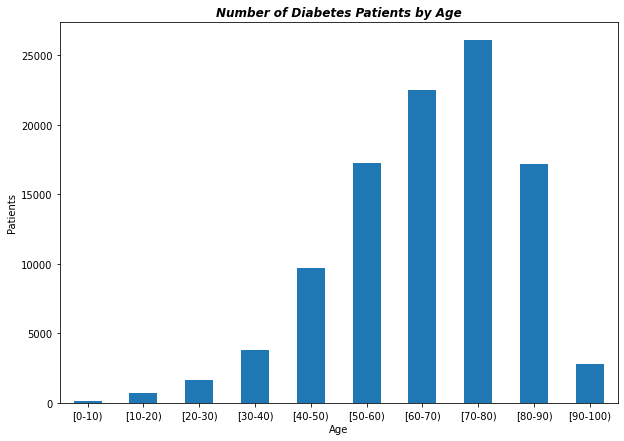

In [0]:
# Number Of Diabetes Patients by Age
fig, ax = plt.subplots(figsize=(10, 7))
hdf.cols['age'].hist(ax=ax)
plt.title("Number of Diabetes Patients by Age", fontstyle='italic', fontdict = {"fontweight": "bold"})
plt.xlabel("Age")
plt.ylabel("Patients")
plt.show()


[(Row(race='Caucasian'), 76099), (Row(race='AfricanAmerican'), 19210), (Row(race='None'), 2273), (Row(race='Hispanic'), 2037), (Row(race='Other'), 1506), (Row(race='Asian'), 641)]


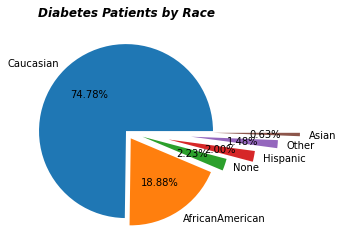

In [0]:
# Diabetes Patients by race
diabetes_property = df.select("race").rdd.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).collect()
diabetes_property = sorted(diabetes_property, key=lambda x: x[1], reverse=True)
print(diabetes_property)

valueList = []
labelList = []
for index in range(len(diabetes_property)):
    valueList.append(diabetes_property[index][1])
    labelList.append(diabetes_property[index][0][0])

explode = [0,0.1,0.2,0.5,0.75,1]
plt.pie(valueList, labels = labelList, autopct='%1.2f%%', explode = explode)

plt.title("Diabetes Patients by Race", fontstyle='italic', fontdict = {"fontweight": "bold"})
plt.show()

[(Row(gender='Unknown/Invalid'), 3), (Row(gender='Female'), 54708), (Row(gender='Male'), 47055)]


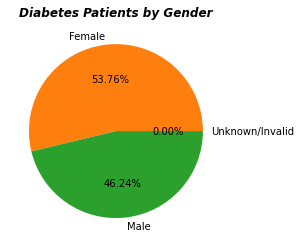

In [0]:
# Diabetes Patients by gender
diabetes_property = df.select("gender").rdd.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).collect()
print(diabetes_property)

valueList = []
labelList = []
for index in range(len(diabetes_property)):
    valueList.append(diabetes_property[index][1])
    labelList.append(diabetes_property[index][0][0])

plt.pie(valueList, labels = labelList, autopct='%1.2f%%')

plt.title("Diabetes Patients by Gender", fontstyle='italic', fontdict = {"fontweight": "bold"})
plt.show()

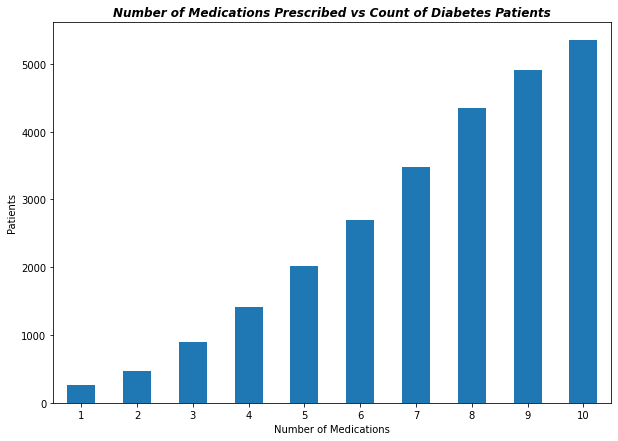

In [0]:
# Number of Medications Prescribed vs Count of Diabetes Patients that are taking that many Medications
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
hdf.cols['num_medications'].hist(ax=ax)

plt.title("Number of Medications Prescribed vs Count of Diabetes Patients", fontstyle='italic', fontdict = {"fontweight": "bold"})
plt.xlabel("Number of Medications")
plt.ylabel("Patients")
plt.show()

[(Row(insulin='No'), 47383), (Row(insulin='Steady'), 30849), (Row(insulin='Up'), 11316), (Row(insulin='Down'), 12218)]


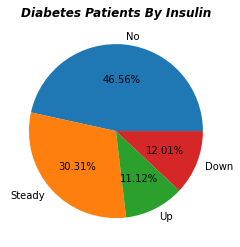

In [0]:
# Diabetes Patients by taking insulin
diabetes_property = df.select("insulin").rdd.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).collect()
print(diabetes_property)

valueList = []
labelList = []
for index in range(len(diabetes_property)):
    valueList.append(diabetes_property[index][1])
    labelList.append(diabetes_property[index][0][0])

plt.pie(valueList, labels = labelList, autopct='%1.2f%%')

plt.title("Diabetes Patients By Insulin", fontstyle='italic', fontdict = {"fontweight": "bold"})
plt.show()

[(Row(diabetesMed=0), 23403), (Row(diabetesMed=1), 78363)]


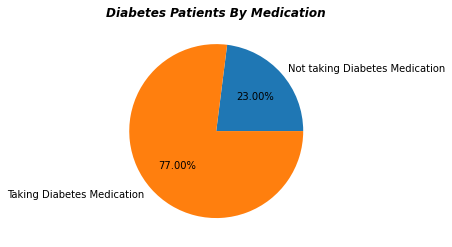

In [0]:
# Diabetes Patients taking medication
diabetesMed_list = df.select("diabetesMed").rdd.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).collect()
print(diabetesMed_list)
onlyValues = [diabetesMed_list[0][1], diabetesMed_list[1][1]]

diabeteslabels = ["Not taking Diabetes Medication", "Taking Diabetes Medication"]
plt.pie(onlyValues, labels = diabeteslabels, autopct='%1.2f%%')

plt.title("Diabetes Patients By Medication", fontstyle='italic', fontdict = {"fontweight": "bold"})
plt.show()

##### ** 2.2 b: Multivariate Analysis**

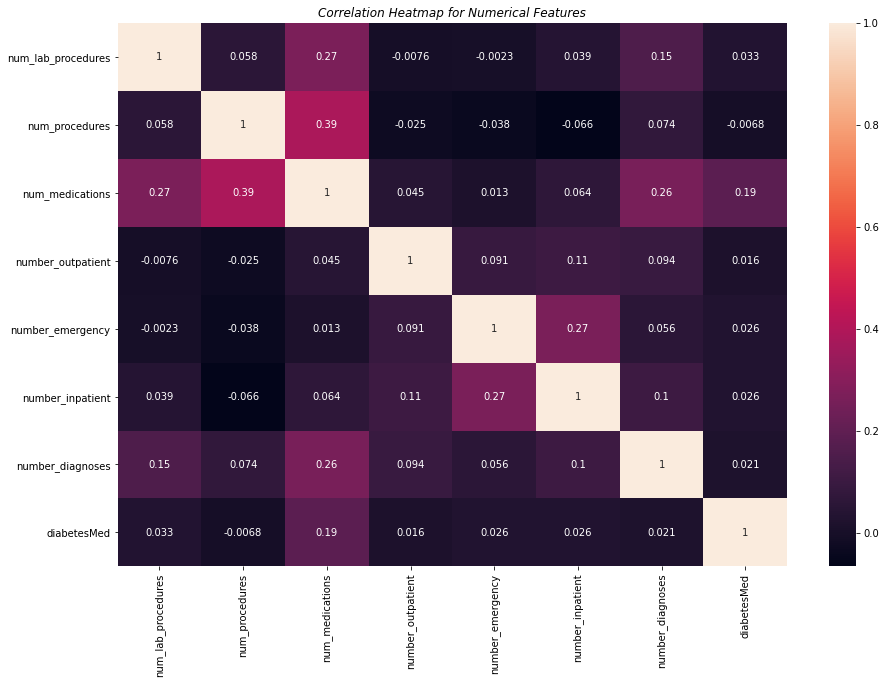

In [0]:
# Numerical data correlation heatmap (diabetesMed is label)
import seaborn as sns

data = hdf.toPandas()
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)

plt.title("Correlation Heatmap for Numerical Features", fontstyle='italic')
plt.show()

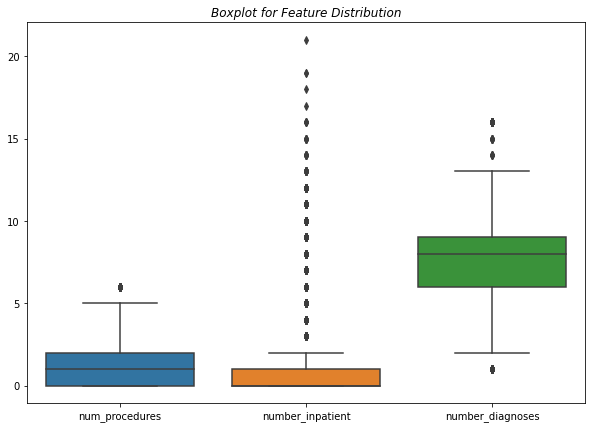

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
df_boxplot = df[['num_procedures', 'number_inpatient', 'number_diagnoses']]
df_boxplot = df_boxplot.toPandas()
sns.boxplot(data=df_boxplot,ax=ax)
plt.title("Boxplot for Feature Distribution", fontstyle='italic')
plt.show()

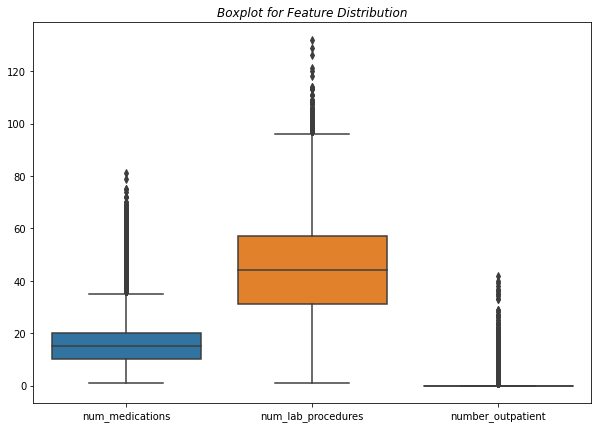

In [0]:
fig, ax = plt.subplots(figsize=(10, 7))
df_boxplot = df[['num_medications', 'num_lab_procedures', 'number_outpatient']]
df_boxplot = df_boxplot.toPandas()
sns.boxplot(data=df_boxplot,ax=ax)
plt.title("Boxplot for Feature Distribution", fontstyle='italic')
plt.show()

## ** Part 3: Create and evaluate a baseline model **

Reference from: https://spark.apache.org/docs/latest/ml-classification-regression.html#classification

#### ** Split into Train, Test, and Cross Validation set **
We will use Train and Test set seperatly for models that supports it. Otherwise, we will simply use trainTestDF for training for models not supporting this.

In [0]:
# split df to only train, test, and cross validation set
# Want to use TrainTestDF for training and validation, and CrossValidationDF for testing on data the model never saw.
trainTestDF, crossValidationDF = df_final.randomSplit([0.8, 0.2], seed=42) #add dataset
trainDF, testDF = trainTestDF.randomSplit([0.75, 0.25], seed=42) #add dataset

print(trainDF.cache().count())
print(testDF.cache().count())
print(crossValidationDF.count())

61442
20177
20147


### ** 3.1: Logistic Regression **

#### ** 3.1 Part A: Logistic Regression - Baseline **

In [0]:
print(trainTestDF.count())
print(crossValidationDF.count())

81619
20147


In [0]:
from pyspark.ml.classification import LogisticRegression

# https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression
lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=1.0)

In [0]:
# Fit the model
lrModel = lr.fit(trainTestDF)

In [0]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: [-0.005674261810615967,-0.00029978391064974254,0.04039900692412055,-0.008897060950645437,0.03539755012174911,-0.006230942474016676,0.006246188872245399,0.0038304068216820156,0.007173716215671036,0.00370583926196474,-0.010744383710942433,-0.0050051450548826495,-0.008988224574908653,-0.04608647949789434,0.02657004790357852,0.0768627328719658,-0.011281286057444493,0.008644034992558784,0.03340726063676694,0.007789682198510815,-0.011161641764102944,-0.028967191792831536,-0.03301168677869679,0.025307569120786293,0.003735543630546778,0.003223291214123296,0.01142936890351059,0.012178231237469058,-0.045416617034911295,-0.07334553112819399,0.04902990631090549,0.006930042044545227,0.002447628886591197,-0.013451225326365977,0.03731853017172289,-0.05539372970058613,-0.022814850271953083,0.0002622045037379941,0.05444808013450016,0.11778305122013215,-0.0006241846564528958,0.09065203955026448,0.038745416985323994,0.06135469445958985,0.07924801187499875,0.029871025789271366,0.177299935695

In [0]:
predicted_df = lrModel.transform(crossValidationDF)
display(predicted_df)

# Make a new DF with only features and labels
plRDD = predicted_df.select("prediction", "label").rdd

predictionAndLabels = plRDD.map(lambda x: (x[0], float(x[1])))

print(predictionAndLabels.collect())

features label rawPrediction probability prediction Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 149, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 6.0, 2.0, 45.0)) 0 Map(vectorType -> dense, length -> 2, values -> List(-0.4942753163561431, 0.4942753163561431)) Map(vectorType -> dense, length -> 2, values -> List(0.3788869308137677, 0.6211130691862323)) 1.0 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 149, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 6.0, 6.0, 1.0, 10.0)) 0 Map(vectorType -> dense, length -> 2, values -> List(-0.4975357451080349, 0.4975357451080349)) Map(vectorType -> dense, length -> 2, values -> List(0.3781199523634083, 0.6218800476365918)) 1.0 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 149, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 14.0, 6.0, 1.0, 33.0)) 0 Map(vectorType -> dense, length -> 2, values -> List(-0.5526333690844565, 0.5526333690844565)) Map(vectorType -> dense, length -> 2, values -> List(0.36525366331990444, 0.6347463366800956)) 1.0 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 149, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 8.0, 1.0, 24.0, 2.0)) 0 Map(vectorType -> dense, length -> 2, values -> List(-0.48661709511935136, 0.48661709511935136)) Map(vectorType -> dense, length -> 2, values -> List(0.38069081676523653, 0.6193091832347635)) 1.0 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 149, 150, 151), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 19.0, 9.0, 2.0, 42.0, 1.0)) 0 Map(vectorType -> dense, length -> 2, values -> List(-0.5954742416418499, 0.5954742416418499)) Map(vectorType -> dense, length -> 2, values -> List(0.35537979719897916, 0.6446202028010208)) 1.0 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 6.0, 49.0)) 0 Map(vectorType -> dense, length -> 2, values -> List(-0.48824545352238946, 0.48824545352238946)) Map(vectorType -> dense, length -> 2, values -> List(0.3803069809829344, 0.6196930190170655)) 1.0 Map(vectorType -> sparse, length -> 152, indices -> List(0, 5, 7, 16, 88, 91, 94, 97, 100, 103, 106, 109, 110, 113, 116, 117, 120, 123, 126, 129, 130, 132, 135, 138, 139, 140, 141, 142, 143, 145, 147, 150), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 9.0, 6.0, 29.0)) 0 Map(vecto

[(1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 0.0), (1.0, 0.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.

In [0]:
# Evaluate model
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Area under PR = 0.7721745172978607
Area under ROC = 0.5


In [0]:
import numpy as np

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

print()
x = metrics.confusionMatrix().toArray()
np.set_printoptions(suppress=True)
print(x)

Summary Stats
Accuracy = 0.7721745172978607
Precision = 0.7721745172978607
Recall = 1.0
F1 Score = 0.8714429755769662

[[    0.  4590.]
 [    0. 15557.]]


#### ** 3.1 Part B: Logistic Regression - Threshhold tuning for maximum F-Measure **

In [0]:
print(trainTestDF.count())
print(crossValidationDF.count())

81619
20147


In [0]:
# Extract the summary from the returned LogisticRegressionModel instance trained
# in the earlier example
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']

print('Best Threshold:', bestThreshold)
lr.setThreshold(bestThreshold)

objectiveHistory:
0.5398771404632794
0.4612041221888803
0.46079342326004746
0.4606653301328901
0.4604920188119102
0.4604419940864254
0.46043390518519195
0.46043020454108696
0.4604302025157614
0.4604302024609308
0.46043020246049154
+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.001289685698818...|
|0.0|0.002579371397637...|
|0.0|0.003869057096455...|
|0.0|0.005158742795274337|
|0.0|0.006448428494092921|
|0.0|0.007738114192911505|
|0.0|0.009027799891730089|
|0.0|0.010317485590548674|
|0.0|0.011607171289367257|
|0.0|0.012896856988185842|
|0.0|0.014186542687004425|
|0.0| 0.01547622838582301|
|0.0|0.016765914084641596|
|0.0|0.018055599783460177|
|0.0|0.019345285482278762|
|0.0|0.020634971181097347|
|0.0|0.021924656879915932|
|0.0|0.023214342578734514|
|0.0|  0.0245040282775531|
+---+--------------------+
only showing top 20 rows

areaUnderROC: 0.9999511285532934
Best Threshold: 0.6918576787358852
Out[54]: LogisticRegression

In [0]:
print('Best Threshold:', bestThreshold)

Best Threshold: 0.6918576787358852


In [0]:
lrModel2 = lr.fit(trainTestDF)

In [0]:
import numpy as np

predicted_df2 = lrModel2.transform(crossValidationDF)

# Make a new DF with only features and labels
plRDD2 = predicted_df2.select("prediction", "label").rdd

predictionAndLabels2 = plRDD2.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels2)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels2)

# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

print()
x = metrics.confusionMatrix().toArray()
np.set_printoptions(suppress=True)
print(x)

Area under PR = 0.9987666324986754
Area under ROC = 0.9973571641736909
Summary Stats
Accuracy = 0.9978160520176701
Precision = 0.9989707301383082
Recall = 0.9982001671273382
F1 Score = 0.9985852999807086

[[ 4574.    16.]
 [   28. 15529.]]


#### ** 3.1 Part C: Logistic Regression - Hyper Parameter Tuning **

In [0]:
print(trainTestDF.count())
print(crossValidationDF.count())

81619
20147


In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

evaluator_cv = BinaryClassificationEvaluator()

lr_cv = LogisticRegression(featuresCol="features", labelCol="label")
lr_cv.setThreshold(bestThreshold)

paramGrid_cv = ParamGridBuilder().addGrid(lr_cv.regParam, [0.5, 0.1, 0.01, 0.0]).addGrid(lr_cv.elasticNetParam, [0, 0.5, 1]).build()

cv2 = CrossValidator(estimator=lr_cv, 
                    estimatorParamMaps=paramGrid_cv, 
                    evaluator=evaluator_cv,
                    numFolds=3)

cvModel2 = cv2.fit(trainTestDF)

In [0]:
bestModel = cvModel2.bestModel
print("Best regParam: ",bestModel._java_obj.getRegParam())
print("Best elasticNetParam: ",bestModel._java_obj.getElasticNetParam())

Best regParam:  0.01
Best elasticNetParam:  0.0


In [0]:
cvModel_Predicted = cvModel2.transform(crossValidationDF)

# Make a new DF with only features and labels
plRDD3 = cvModel_Predicted.select("prediction", "label").rdd

predictionAndLabels3 = plRDD3.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels3)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels3)

# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

print()
x = metrics.confusionMatrix().toArray()
np.set_printoptions(suppress=True)
print(x)

Area under PR = 1.0
Area under ROC = 1.0
Summary Stats
Accuracy = 1.0
Precision = 1.0
Recall = 1.0
F1 Score = 1.0

[[ 4590.     0.]
 [    0. 15557.]]


### ** 3.2: Naives Bayes **

#### ** 3.2 Part A: Naive Bayes - Baseline **

In [0]:
print(trainTestDF.count())
print(crossValidationDF.count())

81619
20147


In [0]:
from pyspark.ml.classification import NaiveBayes

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
nbModel = nb.fit(trainTestDF)

In [0]:
import numpy as np

predicted_df_nb = nbModel.transform(crossValidationDF)

# Make a new DF with only features and labels
plRDD_nb = predicted_df_nb.select("prediction", "label").rdd

predictionAndLabels_nb = plRDD_nb.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels_nb)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels_nb)

# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

print()
x = metrics.confusionMatrix().toArray()
np.set_printoptions(suppress=True)
print(x)

Area under PR = 0.9601666419513222
Area under ROC = 0.9265088829986796
Summary Stats
Accuracy = 0.9597955030525637
Precision = 0.9613339172871176
Recall = 0.9876582888731761
F1 Score = 0.9743183259353202

[[ 3972.   618.]
 [  192. 15365.]]


#### ** 3.2 Part B: Naive Bayes - Hyper Parameter Tuning **

In [0]:
print(trainTestDF.count())
print(crossValidationDF.count())

81619
20147


In [0]:
from pyspark.ml.classification import NaiveBayes

evaluator_cv = BinaryClassificationEvaluator()

nb_cv = NaiveBayes(featuresCol="features", labelCol="label")

paramGrid_nb = ParamGridBuilder().addGrid(nb_cv.smoothing , [0.0, 0.3, 0.6, 1.0]).build()

cv3 = CrossValidator(estimator=nb_cv, 
                    estimatorParamMaps=paramGrid_nb, 
                    evaluator=evaluator_cv,
                    numFolds=3)

cvModel3 = cv3.fit(trainTestDF)

# Make predictions.
nb_predictions2 = cvModel3.transform(crossValidationDF)

In [0]:
bestModel = cvModel3.bestModel
print("Best smoothing: ",bestModel._java_obj.getSmoothing())

Best smoothing:  1.0


In [0]:
# Make a new DF with only features and labels
plRDD_nb2 = nb_predictions2.select("prediction", "label").rdd

predictionAndLabels_nb2 = plRDD_nb2.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels_nb2)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels_nb2)

# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

print()
x = metrics.confusionMatrix().toArray()
np.set_printoptions(suppress=True)
print(x)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Area under PR = 0.9601666419513222
Area under ROC = 0.9265088829986796
Summary Stats
Accuracy = 0.9597955030525637
Precision = 0.9613339172871176
Recall = 0.9876582888731761
F1 Score = 0.9743183259353202

[[ 3972.   618.]
 [  192. 15365.]]


### ** 3.3: Decision Tree **

#### ** 3.3 Part A: Decision Tree - Baseline **

In [0]:
print(trainTestDF.count())
print(crossValidationDF.count())

81619
20147


In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a DecisionTree model.
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Train model.  This also runs the indexers.
dt_model = dt.fit(trainTestDF)

# Make predictions.
dt_predictions = dt_model.transform(crossValidationDF)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dt_predictions)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.0334541 


In [0]:
import numpy as np

# Make a new DF with only features and labels
plRDD_dt = dt_predictions.select("prediction", "label").rdd

predictionAndLabels_dt = plRDD_dt.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels_dt)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels_dt)

# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

print()
x = metrics.confusionMatrix().toArray()
np.set_printoptions(suppress=True)
print(x)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Area under PR = 0.995064781919996
Area under ROC = 0.9783377257826059
Summary Stats
Accuracy = 0.9665458877252197
Precision = 1.0
Recall = 0.9566754515652118
F1 Score = 0.9778580814717477

[[ 4590.     0.]
 [  674. 14883.]]


#### ** 3.3 Part B: Decision Tree - Hyper Parameter Tuning **

In [0]:
print(trainTestDF.count())
print(crossValidationDF.count())

81619
20147


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

evaluator_cv = BinaryClassificationEvaluator()

dt_cv = DecisionTreeClassifier(featuresCol="features", labelCol="label")

paramGrid_dt = ParamGridBuilder().addGrid(dt_cv.maxDepth, [4, 7, 9]).build()

cv4 = CrossValidator(estimator=dt_cv, 
                    estimatorParamMaps=paramGrid_dt, 
                    evaluator=evaluator_cv,
                    numFolds=3)

cvModel4 = cv4.fit(trainTestDF)

# Make predictions.
dt_predictions2 = cvModel4.transform(crossValidationDF)

In [0]:
bestModel = cvModel4.bestModel
print("Best maxDepth: ",bestModel._java_obj.getMaxDepth()) #getMaxDepthParam())

Best maxDepth:  9


In [0]:
# Make a new DF with only features and labels
plRDD_dt_2 = dt_predictions2.select("prediction", "label").rdd

predictionAndLabels_dt_2 = plRDD_dt_2.map(lambda x: (x[0], float(x[1])))

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictionAndLabels_dt_2)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels_dt_2)

# Overall statistics
accuracy = metrics.accuracy
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f1Score = metrics.fMeasure(1.0)
print("Summary Stats")
print("Accuracy = %s" % accuracy)
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

print()
x = metrics.confusionMatrix().toArray()
np.set_printoptions(suppress=True)
print(x)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Area under PR = 0.9996265636170917
Area under ROC = 0.9983608664909687
Summary Stats
Accuracy = 0.997468605747754
Precision = 1.0
Recall = 0.9967217329819373
F1 Score = 0.9983581753211216

[[ 4590.     0.]
 [   51. 15506.]]
